## Install and Import Packages

In [26]:
"""# to install required packages which are listed in the requirements.txt
! pip install -r requirements.txt"""

'# to install required packages which are listed in the requirements.txt\n! pip install -r requirements.txt'

In [5]:
# Import all the packages required for ticket classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import time
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from scipy.spatial import distance
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")

# Read Data

In [6]:
tktdata = pd.read_csv("all_tickets.csv")

In [7]:
print(tktdata.shape)
tktdata.head()

(48549, 9)


,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


In [8]:
tktdata.isnull().sum()

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64

# Data Analysis

#missing values 

In [9]:
tktdata = tktdata.dropna()
tktdata.isnull().sum()

title               0
body                0
ticket_type         0
category            0
sub_category1       0
sub_category2       0
business_service    0
urgency             0
impact              0
dtype: int64

In [10]:
tktdata.shape

(47837, 9)

<p> As there are no missing values in the dataset, we will proceed with our investigation.



#Dropping duplicates if any

In [11]:
tktdata.drop_duplicates(inplace=True)

In [12]:
tktdata.shape

(47837, 9)

#Merging Title and Text data

In [13]:
tktdata['act_text'] = tktdata['title'] +' '+ tktdata['body']
tktdata['act_text'].head()

1    connection with icon icon dear please setup ic...
2    work experience user work experience user hi w...
3    requesting for meeting requesting meeting hi p...
4    reset passwords for external accounts re expir...
5    mail verification warning hi has got attached ...
Name: act_text, dtype: object

#### Exploratory Data Analysis

[Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')]

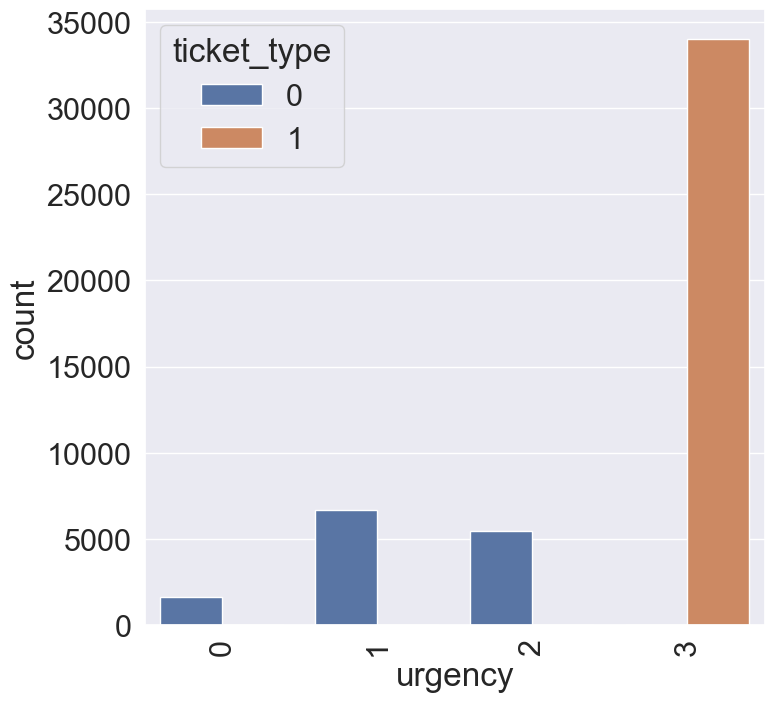

In [14]:
plt.figure(figsize = (8,8))
sns.set(style = "darkgrid",font_scale = 2)
chart = sns.countplot(x = "urgency", hue = "ticket_type" , data = tktdata)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<Axes: xlabel='ticket_type', ylabel='count'>

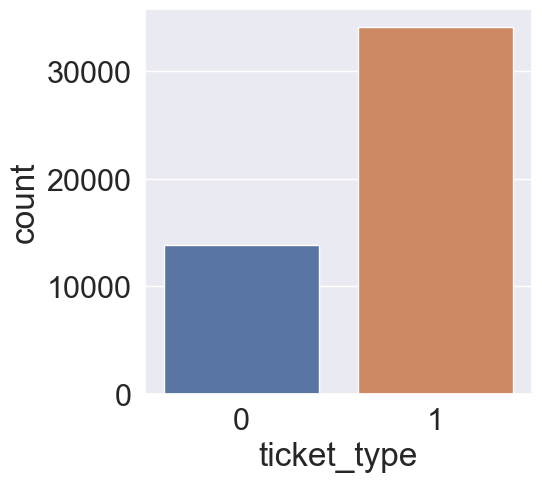

In [15]:
plt.figure(figsize=(5,5))
sns.countplot(x= "ticket_type", data=tktdata)

<Axes: xlabel='category', ylabel='count'>

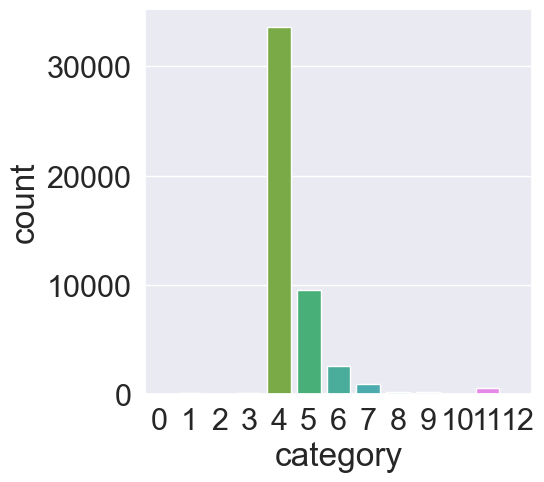

In [16]:
plt.figure(figsize=(5,5))
sns.countplot(x= "category", data=tktdata)

In [17]:
final_data = tktdata[['act_text', 'category','ticket_type','impact']]
final_data.head()

,act_text,category,ticket_type,impact
1,connection with icon icon dear please setup ic...,6,1,4
2,work experience user work experience user hi w...,5,1,4
3,requesting for meeting requesting meeting hi p...,5,1,4
4,reset passwords for external accounts re expir...,4,1,4
5,mail verification warning hi has got attached ...,4,1,4


# Data Cleaning

#### Text Preprocessing for Stemmed and Lemmatized Corpus

In [18]:
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [19]:
'''# Please run once to download nltk modules
nltk.download('all')'''

"# Please run once to download nltk modules\nnltk.download('all')"

In [20]:
# for text stemming and lemmatization
stemmed_text = []
lemmatized_text = []
eff_text_result = []
for text in final_data['act_text']:
    result = re.sub('[^a-zA-Z]', ' ', text)
    result = result.lower()
    result = result.split()
    result = [r for r in result if r not in set(stopwords.words('english'))]
    eff_text_result.append(" ".join(result))
    stemmed_result = [porter_stemmer.stem(r) for r in result]
    stemmed_text.append(" ".join(stemmed_result))
    lemmatized_result = [lemmatizer.lemmatize(r) for r in result]
    lemmatized_text.append(" ".join(lemmatized_result))

In [21]:
np.save('eff_text_result.npy', eff_text_result)
np.save('stemmed_text.npy', stemmed_text)
np.save('lemmatized_text.npy', lemmatized_text)

In [22]:
stemmed_text = np.load('stemmed_text.npy')

In [23]:
print(len(stemmed_text))

47837


In [24]:
head_10 = lemmatized_text[:10]

# Tokenization
tokenized_text = [word_tokenize(text) for text in head_10]

df = pd.DataFrame({'Original Text': head_10, 
                   'Lemmatized Text': lemmatized_text[:10], 
                   'Stemmed Text': stemmed_text[:10], 
                   'Tokenized Text': tokenized_text, 
                   'Stopword Removed Text': eff_text_result[:10]})

df.head()


,Original Text,Lemmatized Text,Stemmed Text,Tokenized Text,Stopword Removed Text
0,connection icon icon dear please setup icon pe...,connection icon icon dear please setup icon pe...,connect icon icon dear pleas setup icon per ic...,"[connection, icon, icon, dear, please, setup, ...",connection icon icon dear please setup icon pe...
1,work experience user work experience user hi w...,work experience user work experience user hi w...,work experi user work experi user hi work expe...,"[work, experience, user, work, experience, use...",work experience user work experience user hi w...
2,requesting meeting requesting meeting hi pleas...,requesting meeting requesting meeting hi pleas...,request meet request meet hi pleas help follow...,"[requesting, meeting, requesting, meeting, hi,...",requesting meeting requesting meeting hi pleas...
3,reset password external account expire day hi ...,reset password external account expire day hi ...,reset password extern account expir day hi ask...,"[reset, password, external, account, expire, d...",reset passwords external accounts expire days ...
4,mail verification warning hi got attached plea...,mail verification warning hi got attached plea...,mail verif warn hi got attach pleas address be...,"[mail, verification, warning, hi, got, attache...",mail verification warning hi got attached plea...


### WordCloud 

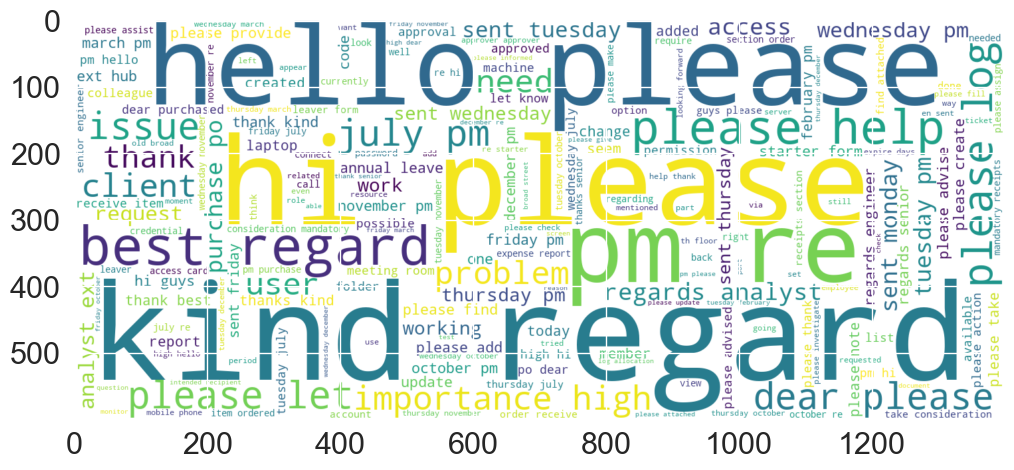

In [25]:
plt.figure(figsize=(12,12))
wc=WordCloud(max_words=200, width=1400, height=600,background_color='white', stopwords=STOPWORDS).generate("".join(final_data.act_text))
plt.imshow(wc, interpolation="bilinear")

In [26]:
def get_ngrams(text, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### unigrams

Text(0.5, 0, 'Occurrences')

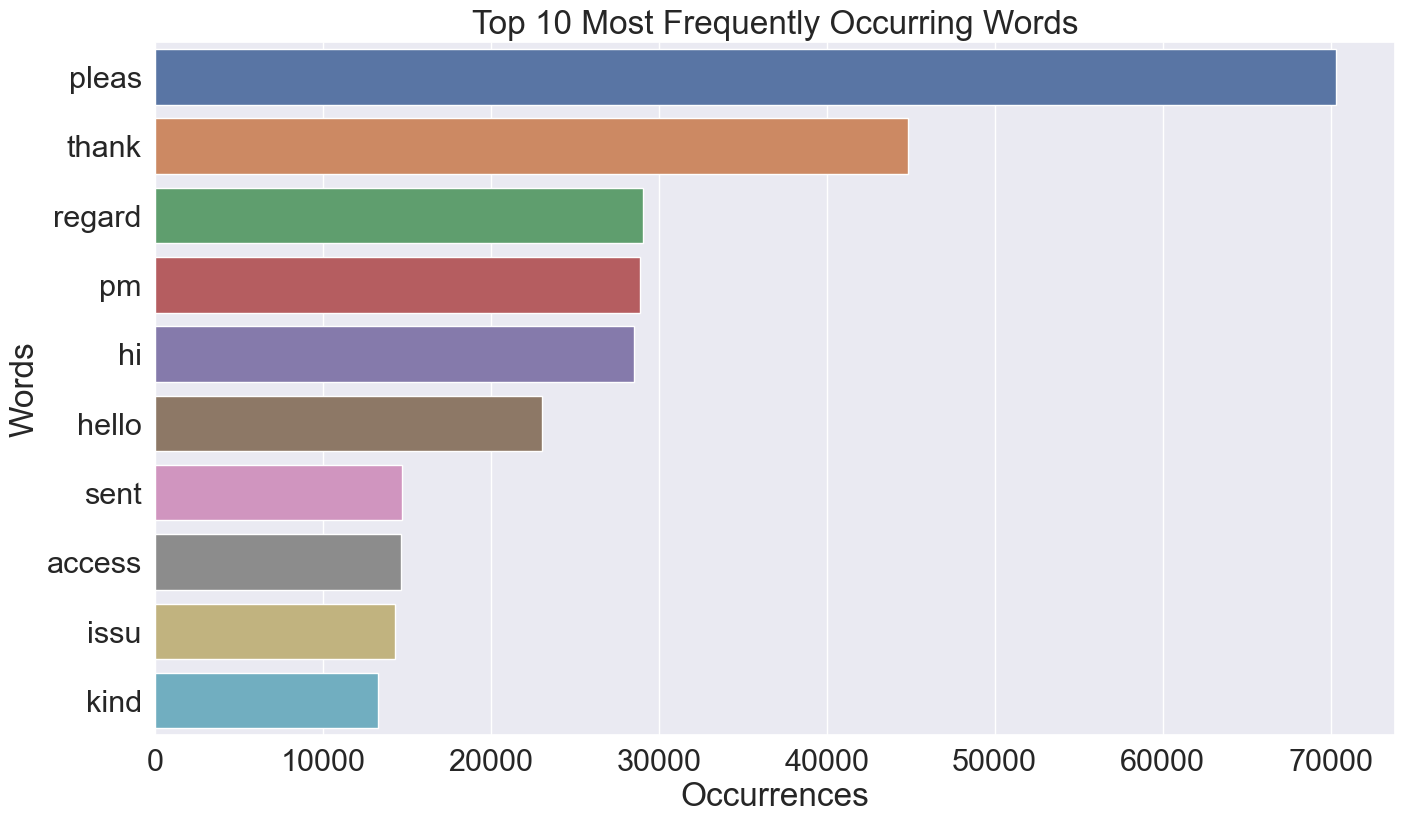

In [27]:
plt.figure(figsize = (16,9))
most_common_uni = get_ngrams(stemmed_text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.title('Top 10 Most Frequently Occurring Words')
plt.ylabel('Words')
plt.xlabel('Occurrences')

#### 'pleas' is the most occuring word in the corpus

### Trigrams

Text(0.5, 0, 'Frequency')

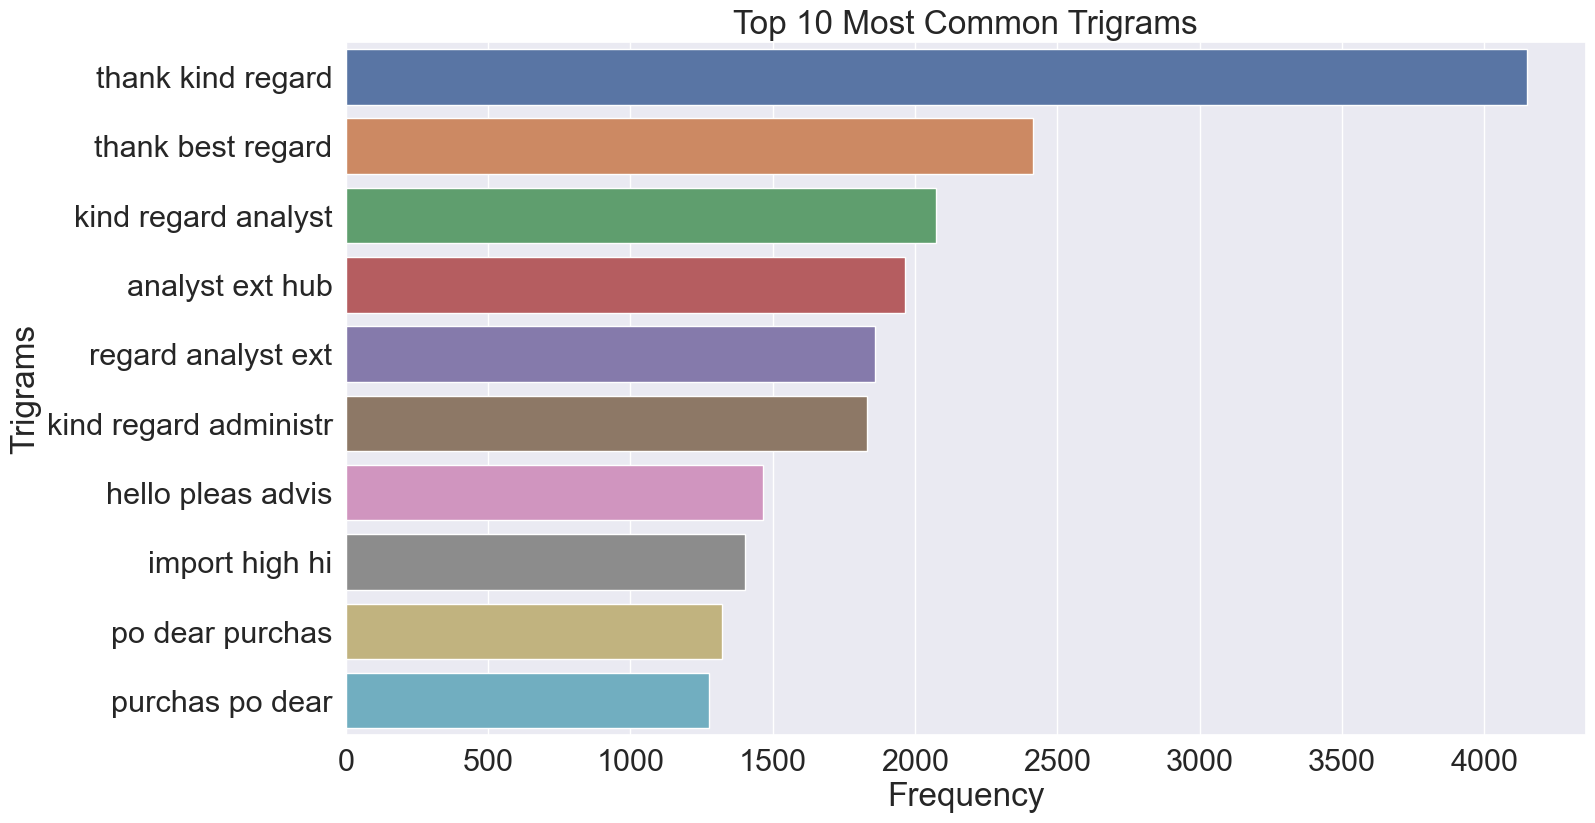

In [28]:
plt.figure(figsize = (16,9))
most_common_uni = get_ngrams(stemmed_text,10,3)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.title('Top 10 Most Common Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Frequency')

## Build models utilizing both CountVectorizer and TFIDF Vectorizer on both the stemmed text and lemmatized text.

In [30]:



# Define a function for plotting the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.set()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# Define a function to plot the class distribution
def plot_class_distribution(y, title):
    plt.figure(figsize=(3, 2))
    sns.countplot(x=y)
    plt.title(title)
    plt.show()

# Define a function to get and print prediction results with SMOTE


def get_prediction_with_smote(vectorizer, classifier, X_train, X_test, y_train, y_test):
    # Print class distribution before SMOTE
    plot_class_distribution(y_train, "Class Distribution Before SMOTE")

    # Vectorize the text data
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)
    
    plot_class_distribution(y_train_resampled, "Class Distribution After SMOTE")
    
    pipe = Pipeline([('model', classifier)])
    model = pipe.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_vec)
    
# Calculating and printing the confusion matrix parameters 

    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))
    
    train_accuracy = accuracy_score(y_train_resampled, model.predict(X_train_resampled))
    print("Train Accuracy: {:.2f}%".format(train_accuracy * 100))
    
    precision = precision_score(y_test, y_pred, average='weighted')
    print("Test Precision: {:.2f}".format(precision))
    
    recall = recall_score(y_test, y_pred, average='weighted')
    print("Test Recall: {:.2f}".format(recall))
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Test F1-Score: {:.2f}".format(f1))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Test Confusion Matrix: \n", cm)
    
    plot_confusion_matrix(y_test, y_pred, classes=np.unique(y_test))

    


***Input Stemmed text***


 SVC(kernel='linear')
********Count Vectorizer on Stemmed text*************


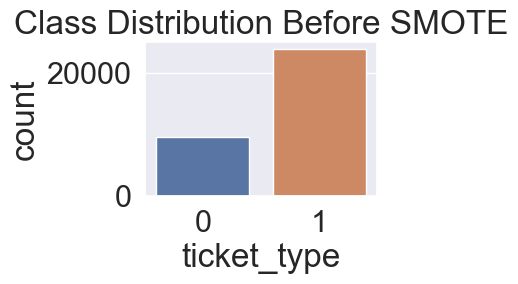

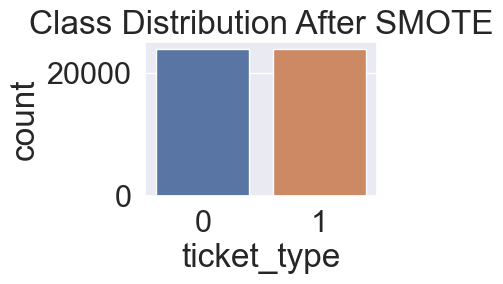

Test Accuracy: 96.22%
Train Accuracy: 98.70%
Test Precision: 0.96
Test Recall: 0.96
Test F1-Score: 0.96
Test Confusion Matrix: 
 [[4009  152]
 [ 391 9800]]


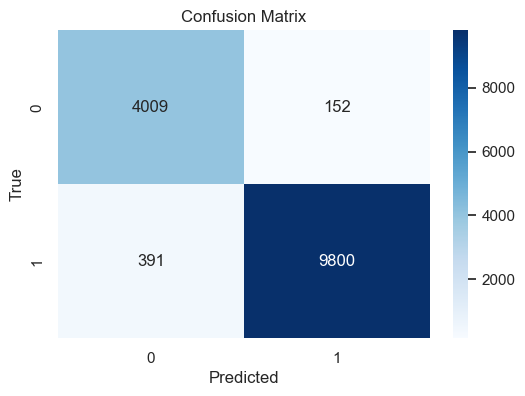

********TF-IDF Vectorizer on Stemmed text*************


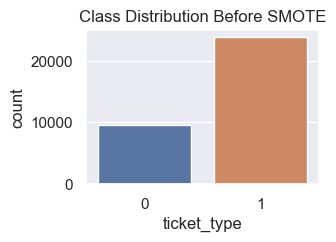

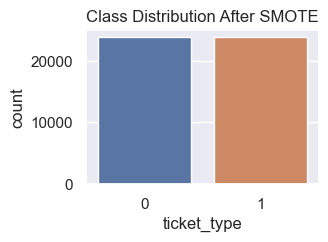

Test Accuracy: 97.65%
Train Accuracy: 98.75%
Test Precision: 0.98
Test Recall: 0.98
Test F1-Score: 0.98
Test Confusion Matrix: 
 [[ 4012   149]
 [  188 10003]]


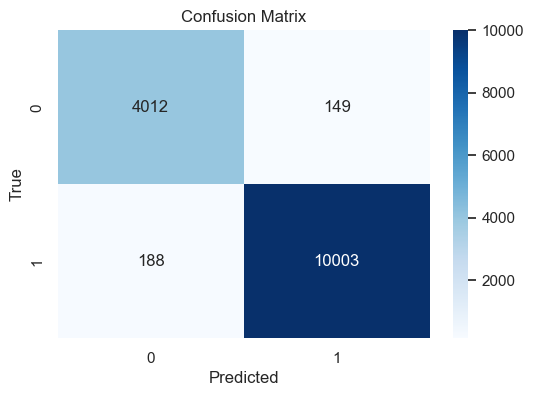



 KNeighborsClassifier(n_neighbors=30)
********Count Vectorizer on Stemmed text*************


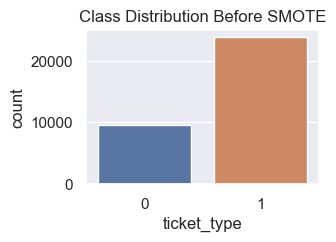

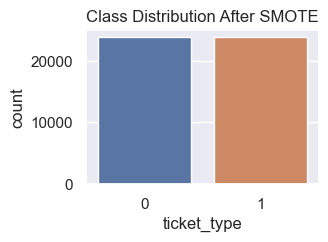

Test Accuracy: 70.49%
Train Accuracy: 80.06%
Test Precision: 0.83
Test Recall: 0.70
Test F1-Score: 0.72
Test Confusion Matrix: 
 [[3960  201]
 [4034 6157]]


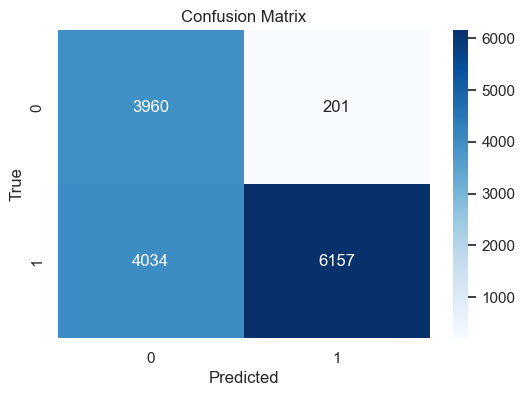

********TF-IDF Vectorizer on Stemmed text*************


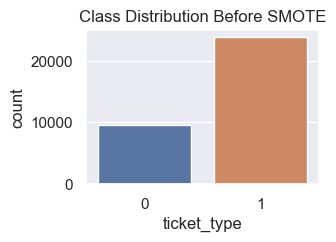

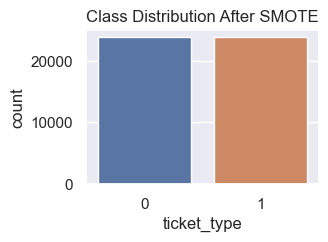

Test Accuracy: 71.78%
Train Accuracy: 80.57%
Test Precision: 0.83
Test Recall: 0.72
Test F1-Score: 0.73
Test Confusion Matrix: 
 [[3938  223]
 [3827 6364]]


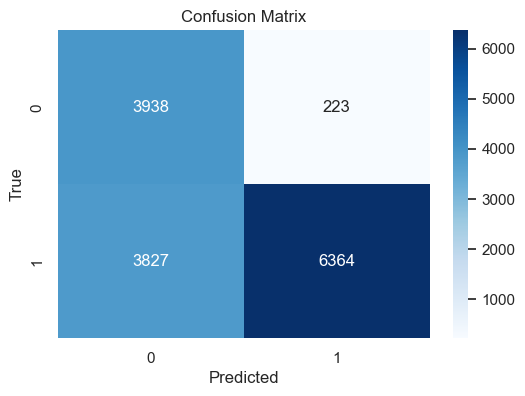



 GradientBoostingClassifier()
********Count Vectorizer on Stemmed text*************


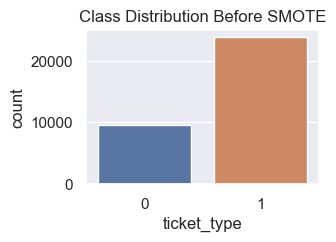

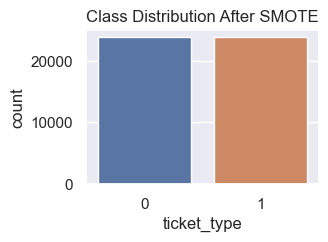

Test Accuracy: 94.39%
Train Accuracy: 94.53%
Test Precision: 0.95
Test Recall: 0.94
Test F1-Score: 0.94
Test Confusion Matrix: 
 [[3955  206]
 [ 599 9592]]


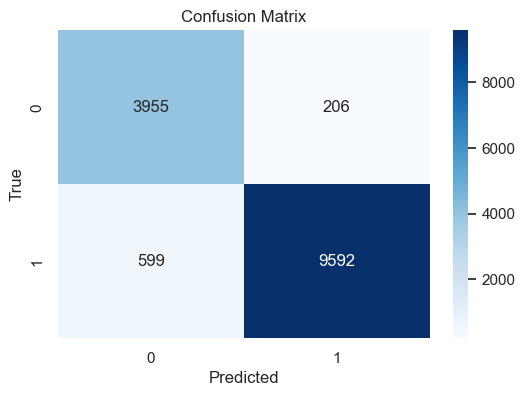

********TF-IDF Vectorizer on Stemmed text*************


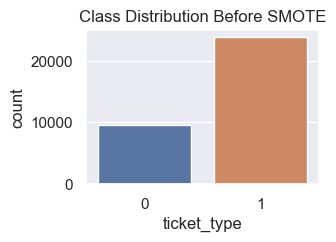

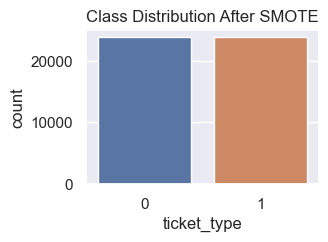

Test Accuracy: 95.88%
Train Accuracy: 96.66%
Test Precision: 0.96
Test Recall: 0.96
Test F1-Score: 0.96
Test Confusion Matrix: 
 [[ 3741   420]
 [  171 10020]]


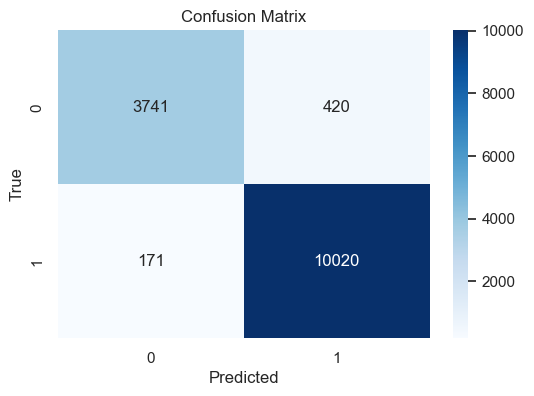



 RandomForestClassifier()
********Count Vectorizer on Stemmed text*************


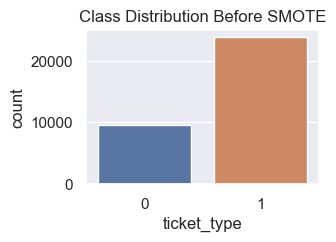

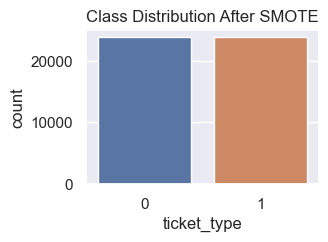

Test Accuracy: 96.36%
Train Accuracy: 99.99%
Test Precision: 0.97
Test Recall: 0.96
Test F1-Score: 0.96
Test Confusion Matrix: 
 [[4044  117]
 [ 406 9785]]


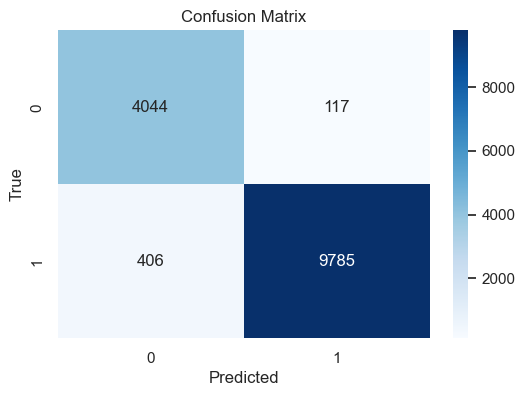

********TF-IDF Vectorizer on Stemmed text*************


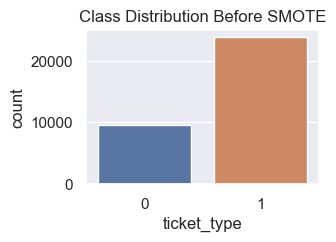

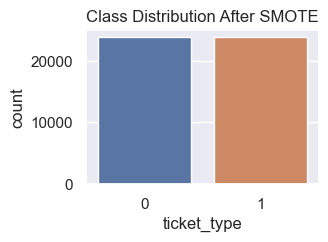

Test Accuracy: 97.36%
Train Accuracy: 100.00%
Test Precision: 0.97
Test Recall: 0.97
Test F1-Score: 0.97
Test Confusion Matrix: 
 [[3995  166]
 [ 213 9978]]


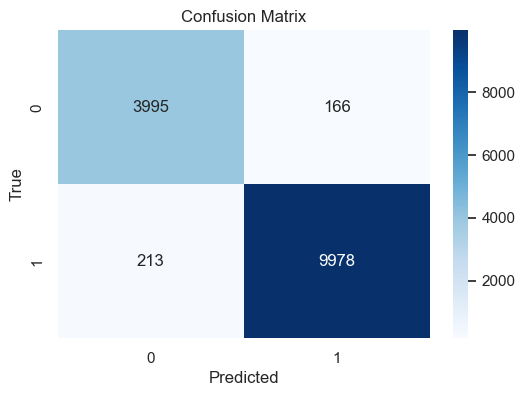



 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
********Count Vectorizer on Stemmed text*************


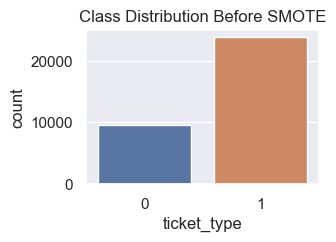

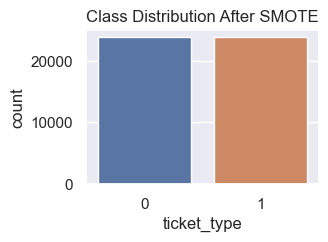

Test Accuracy: 97.71%
Train Accuracy: 99.11%
Test Precision: 0.98
Test Recall: 0.98
Test F1-Score: 0.98
Test Confusion Matrix: 
 [[ 3953   208]
 [  121 10070]]


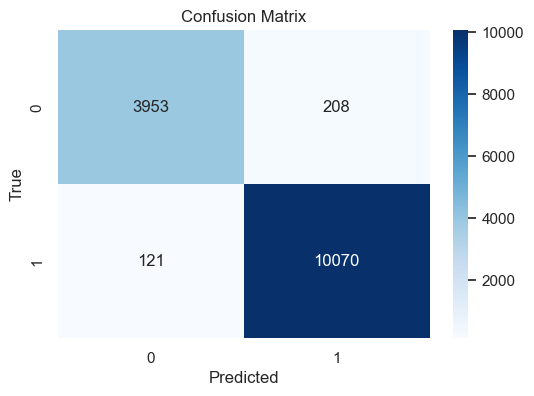

********TF-IDF Vectorizer on Stemmed text*************


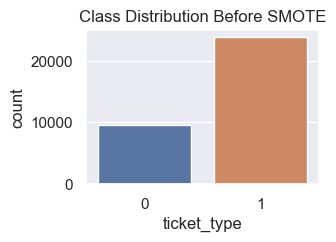

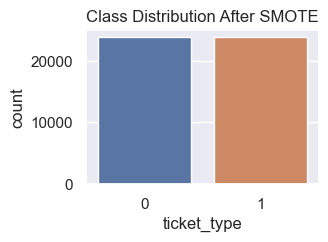

Test Accuracy: 97.53%
Train Accuracy: 99.25%
Test Precision: 0.98
Test Recall: 0.98
Test F1-Score: 0.98
Test Confusion Matrix: 
 [[ 3951   210]
 [  145 10046]]


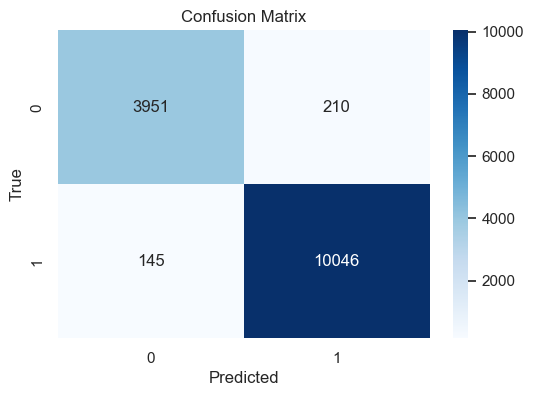

In [31]:
print("***Input Stemmed text***")
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(stemmed_text,tktdata['ticket_type'], test_size = 0.3, random_state= 0)

# List of classifers to evaluate
classifiers = [SVC(kernel='linear'),KNeighborsClassifier(n_neighbors=30),GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("********Count Vectorizer on Stemmed text*************")
    get_prediction_with_smote(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("********TF-IDF Vectorizer on Stemmed text*************")
    get_prediction_with_smote(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

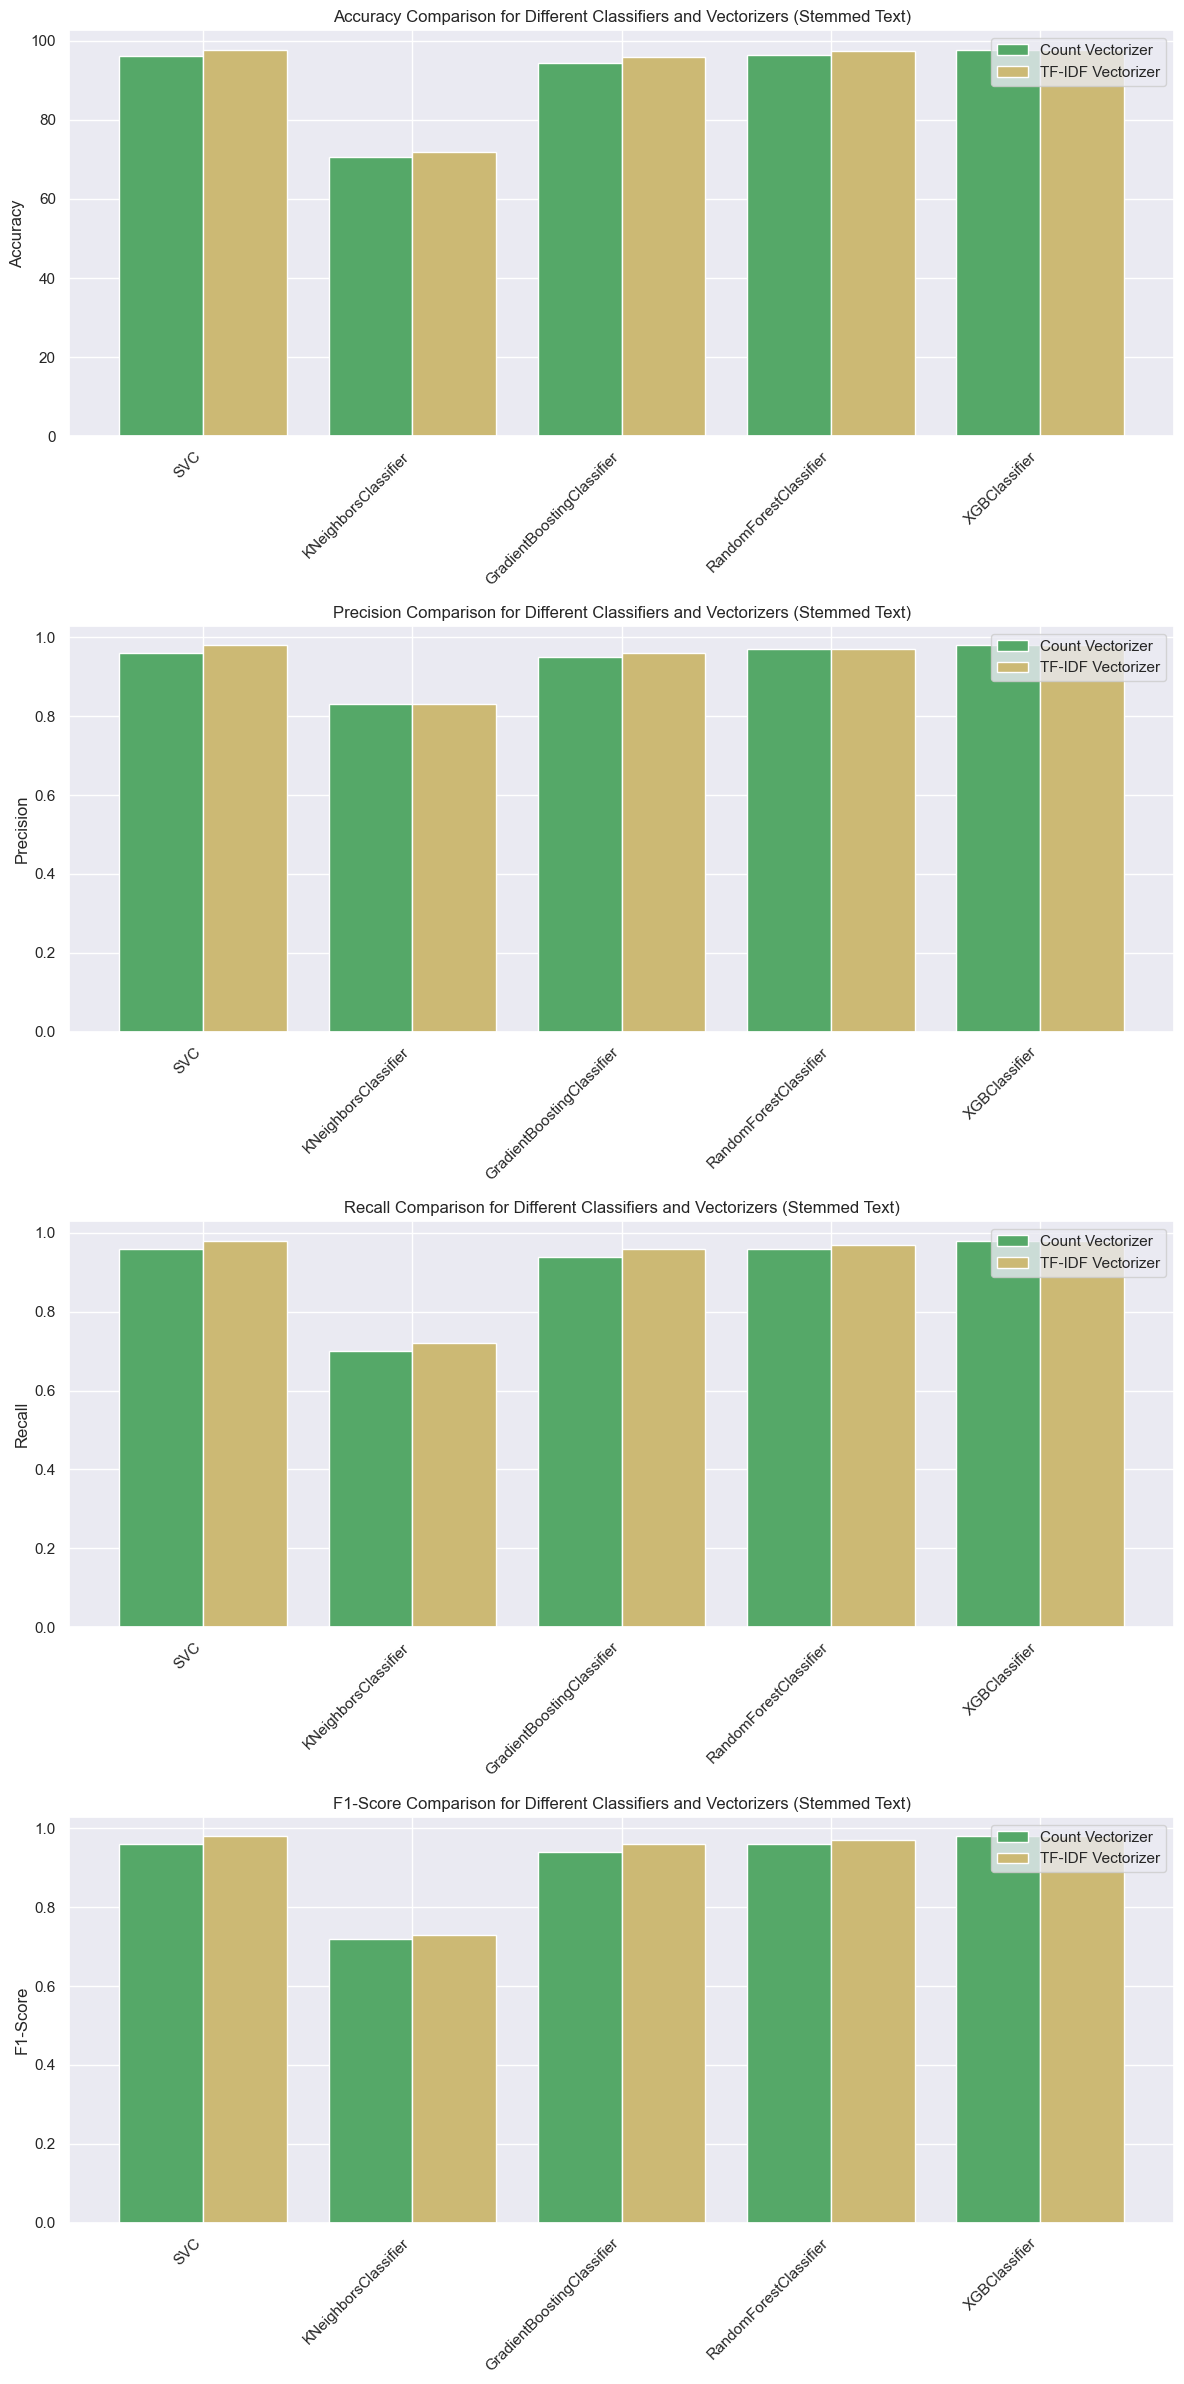

In [96]:

classifiers = [
    'SVC', 'KNeighborsClassifier',
    'GradientBoostingClassifier', 'RandomForestClassifier',
    'XGBClassifier'
]

# result parameters for Count Vectorizer and TF-IDF Vectorizer on stemmed text
test_metrics_count_vectorizer = {
    'Accuracy': [96.22, 70.49, 94.39, 96.36, 97.71],
    'Precision': [0.96, 0.83, 0.95, 0.97, 0.98],
    'Recall': [0.96, 0.70, 0.94, 0.96, 0.98],
    'F1-Score': [0.96, 0.72, 0.94, 0.96, 0.98]
}

test_metrics_tfidf_vectorizer = {
    'Accuracy': [97.65, 71.78, 95.88, 97.36, 97.53],
    'Precision': [0.98, 0.83, 0.96, 0.97, 0.98],
    'Recall': [0.98, 0.72, 0.96, 0.97, 0.98],
    'F1-Score': [0.98, 0.73, 0.96, 0.97, 0.98]
}

colors = ['g', 'y']

# Create subplots for each parameter
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
num_metrics = len(metrics)

fig, axs = plt.subplots(num_metrics, 1, figsize=(12, 6*num_metrics))

for i, metric in enumerate(metrics):
    ax = axs[i]
    
    x_pos = np.arange(len(classifiers))
    bar_width = 0.4
    
    ax.bar(x_pos - bar_width/2, test_metrics_count_vectorizer[metric], bar_width, label='Count Vectorizer', color=colors[0])
    ax.bar(x_pos + bar_width/2, test_metrics_tfidf_vectorizer[metric], bar_width, label='TF-IDF Vectorizer', color=colors[1])
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison for Different Classifiers and Vectorizers (Stemmed Text)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(classifiers, rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.show()


In [32]:
vectorizer = TfidfVectorizer(lowercase=False)
rf = RandomForestClassifier()
pipe = Pipeline([('vector', vectorizer),
                    ('model', rf)])
model = pipe.fit(X_train, y_train)
idx = 83

In [33]:
pred = model.predict(X_test[idx-1:idx+1])

In [34]:
lemmatized_text = np.load('lemmatized_text.npy')

**Input Lemmatized text***


 SVC(kernel='linear')
********Count Vectorizer on Lemmatized text*************


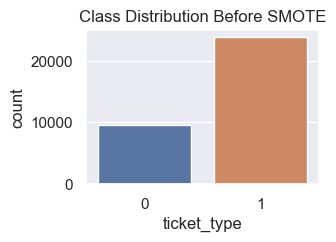

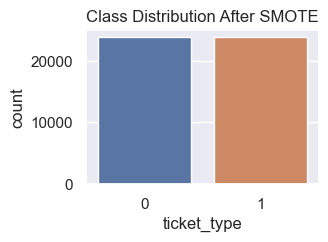

Test Accuracy: 96.68%
Train Accuracy: 99.05%
Test Precision: 0.97
Test Recall: 0.97
Test F1-Score: 0.97
Test Confusion Matrix: 
 [[4024  137]
 [ 340 9851]]


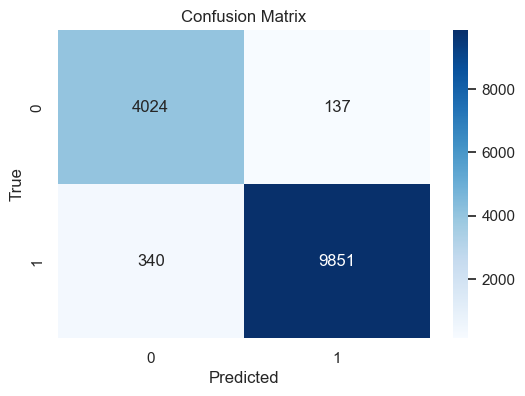

********TF-IDF Vectorizer on Stemmed text*************


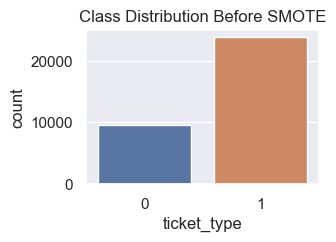

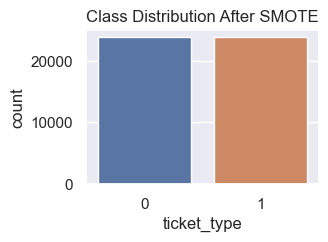

Test Accuracy: 97.81%
Train Accuracy: 99.07%
Test Precision: 0.98
Test Recall: 0.98
Test F1-Score: 0.98
Test Confusion Matrix: 
 [[ 4010   151]
 [  164 10027]]


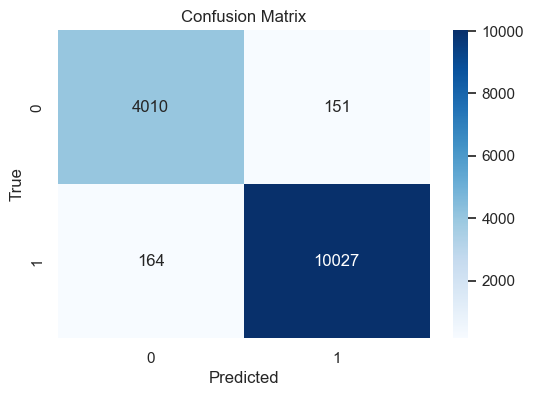



 KNeighborsClassifier(n_neighbors=30)
********Count Vectorizer on Lemmatized text*************


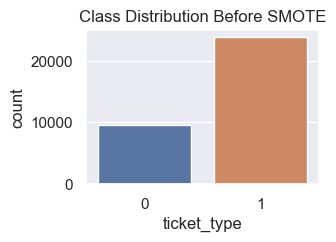

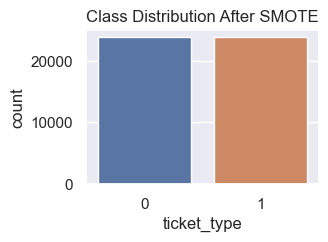

Test Accuracy: 67.73%
Train Accuracy: 78.13%
Test Precision: 0.82
Test Recall: 0.68
Test F1-Score: 0.69
Test Confusion Matrix: 
 [[3972  189]
 [4443 5748]]


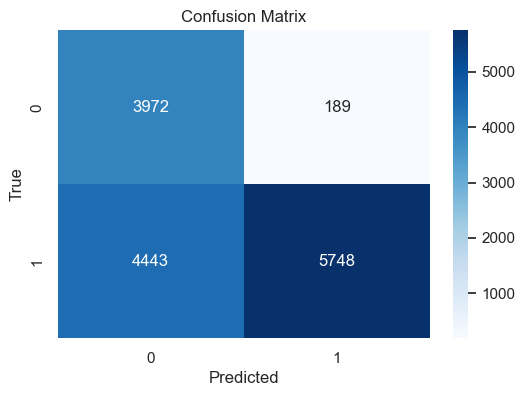

********TF-IDF Vectorizer on Stemmed text*************


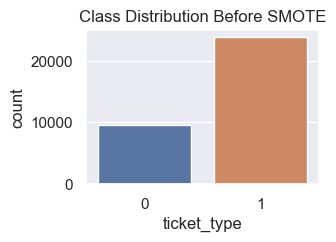

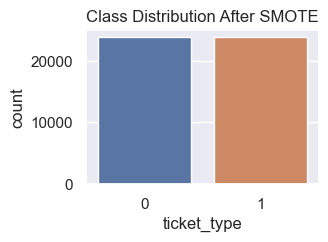

Test Accuracy: 70.60%
Train Accuracy: 79.85%
Test Precision: 0.83
Test Recall: 0.71
Test F1-Score: 0.72
Test Confusion Matrix: 
 [[3963  198]
 [4022 6169]]


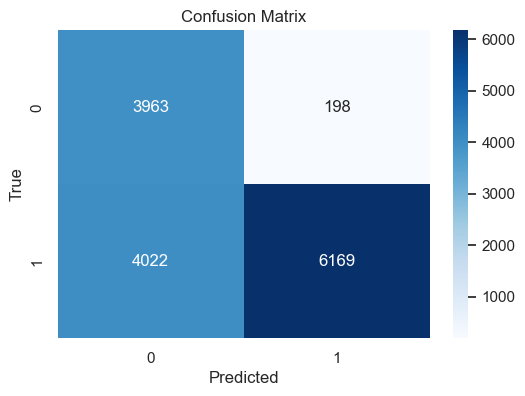



 GradientBoostingClassifier()
********Count Vectorizer on Lemmatized text*************


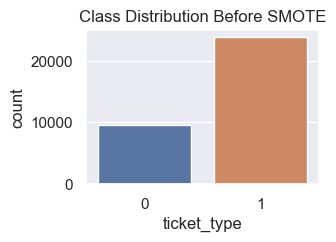

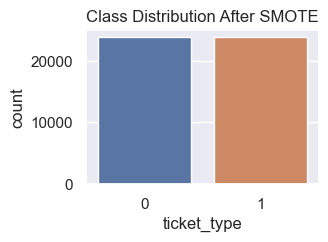

Test Accuracy: 94.21%
Train Accuracy: 94.77%
Test Precision: 0.95
Test Recall: 0.94
Test F1-Score: 0.94
Test Confusion Matrix: 
 [[3948  213]
 [ 618 9573]]


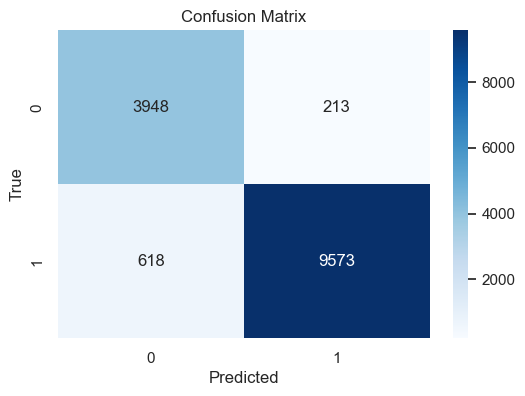

********TF-IDF Vectorizer on Stemmed text*************


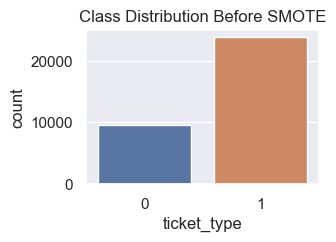

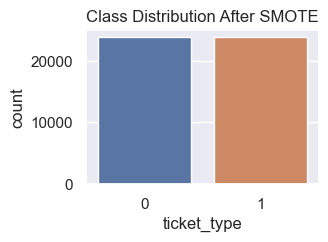

Test Accuracy: 96.05%
Train Accuracy: 96.76%
Test Precision: 0.96
Test Recall: 0.96
Test F1-Score: 0.96
Test Confusion Matrix: 
 [[ 3749   412]
 [  155 10036]]


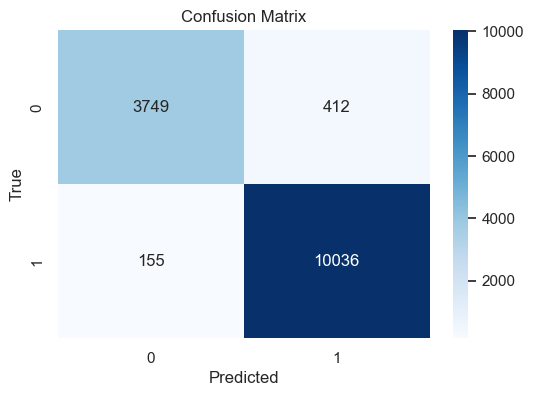



 RandomForestClassifier()
********Count Vectorizer on Lemmatized text*************


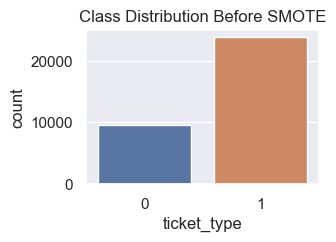

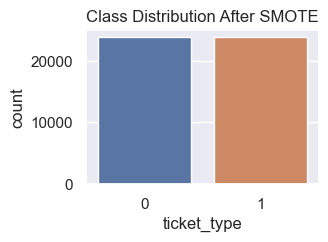

Test Accuracy: 96.47%
Train Accuracy: 100.00%
Test Precision: 0.97
Test Recall: 0.96
Test F1-Score: 0.97
Test Confusion Matrix: 
 [[4062   99]
 [ 408 9783]]


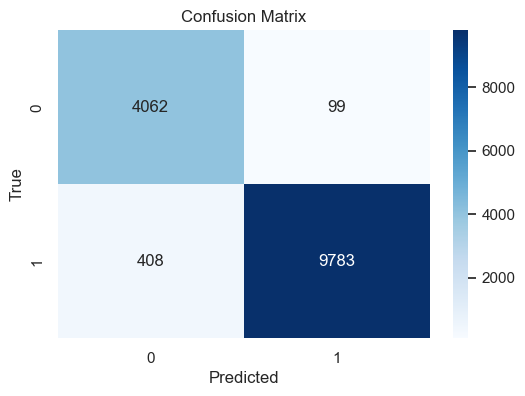

********TF-IDF Vectorizer on Stemmed text*************


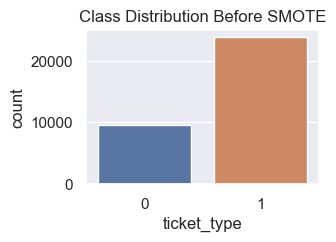

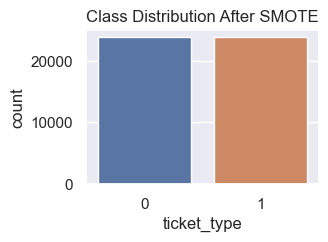

Test Accuracy: 97.74%
Train Accuracy: 100.00%
Test Precision: 0.98
Test Recall: 0.98
Test F1-Score: 0.98
Test Confusion Matrix: 
 [[ 4003   158]
 [  166 10025]]


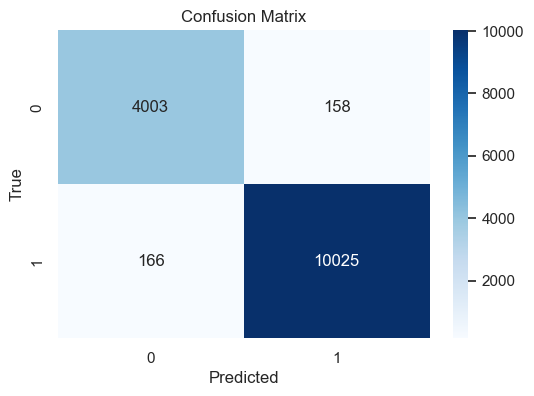



 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
********Count Vectorizer on Lemmatized text*************


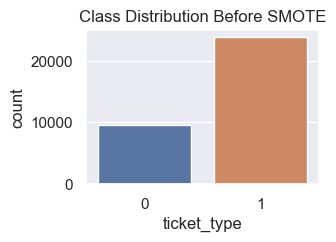

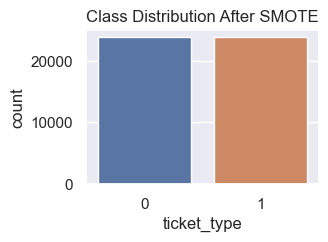

Test Accuracy: 97.94%
Train Accuracy: 99.16%
Test Precision: 0.98
Test Recall: 0.98
Test F1-Score: 0.98
Test Confusion Matrix: 
 [[ 3963   198]
 [   97 10094]]


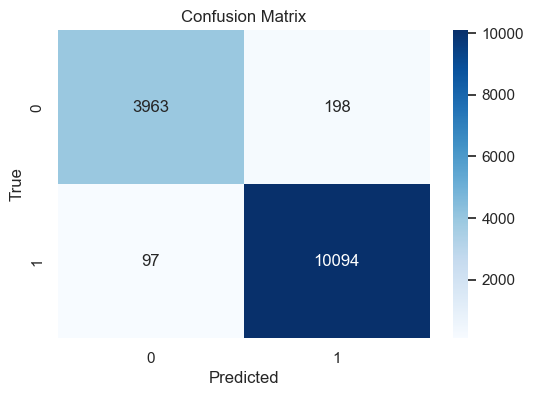

********TF-IDF Vectorizer on Stemmed text*************


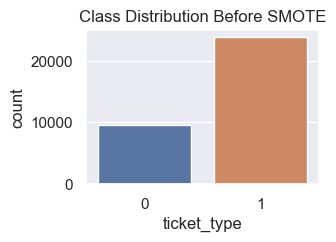

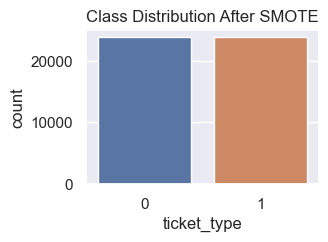

Test Accuracy: 97.69%
Train Accuracy: 99.23%
Test Precision: 0.98
Test Recall: 0.98
Test F1-Score: 0.98
Test Confusion Matrix: 
 [[ 3944   217]
 [  115 10076]]


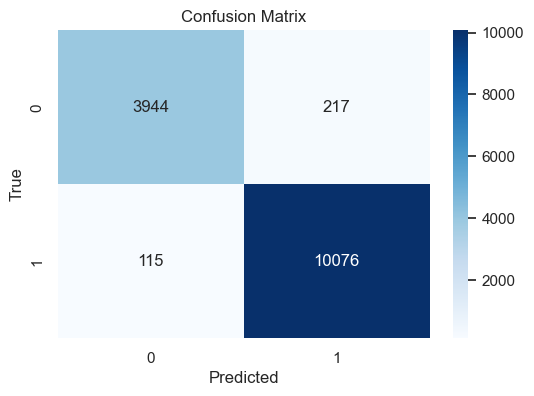

In [35]:
print("**Input Lemmatized text***")

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lemmatized_text, tktdata['ticket_type'], test_size = 0.3, random_state= 0)
# List of classifers to evaluate
classifiers = [SVC(kernel='linear'),KNeighborsClassifier(n_neighbors=30),GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("********Count Vectorizer on Lemmatized text*************")
    get_prediction_with_smote(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("********TF-IDF Vectorizer on Stemmed text*************")
    get_prediction_with_smote(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

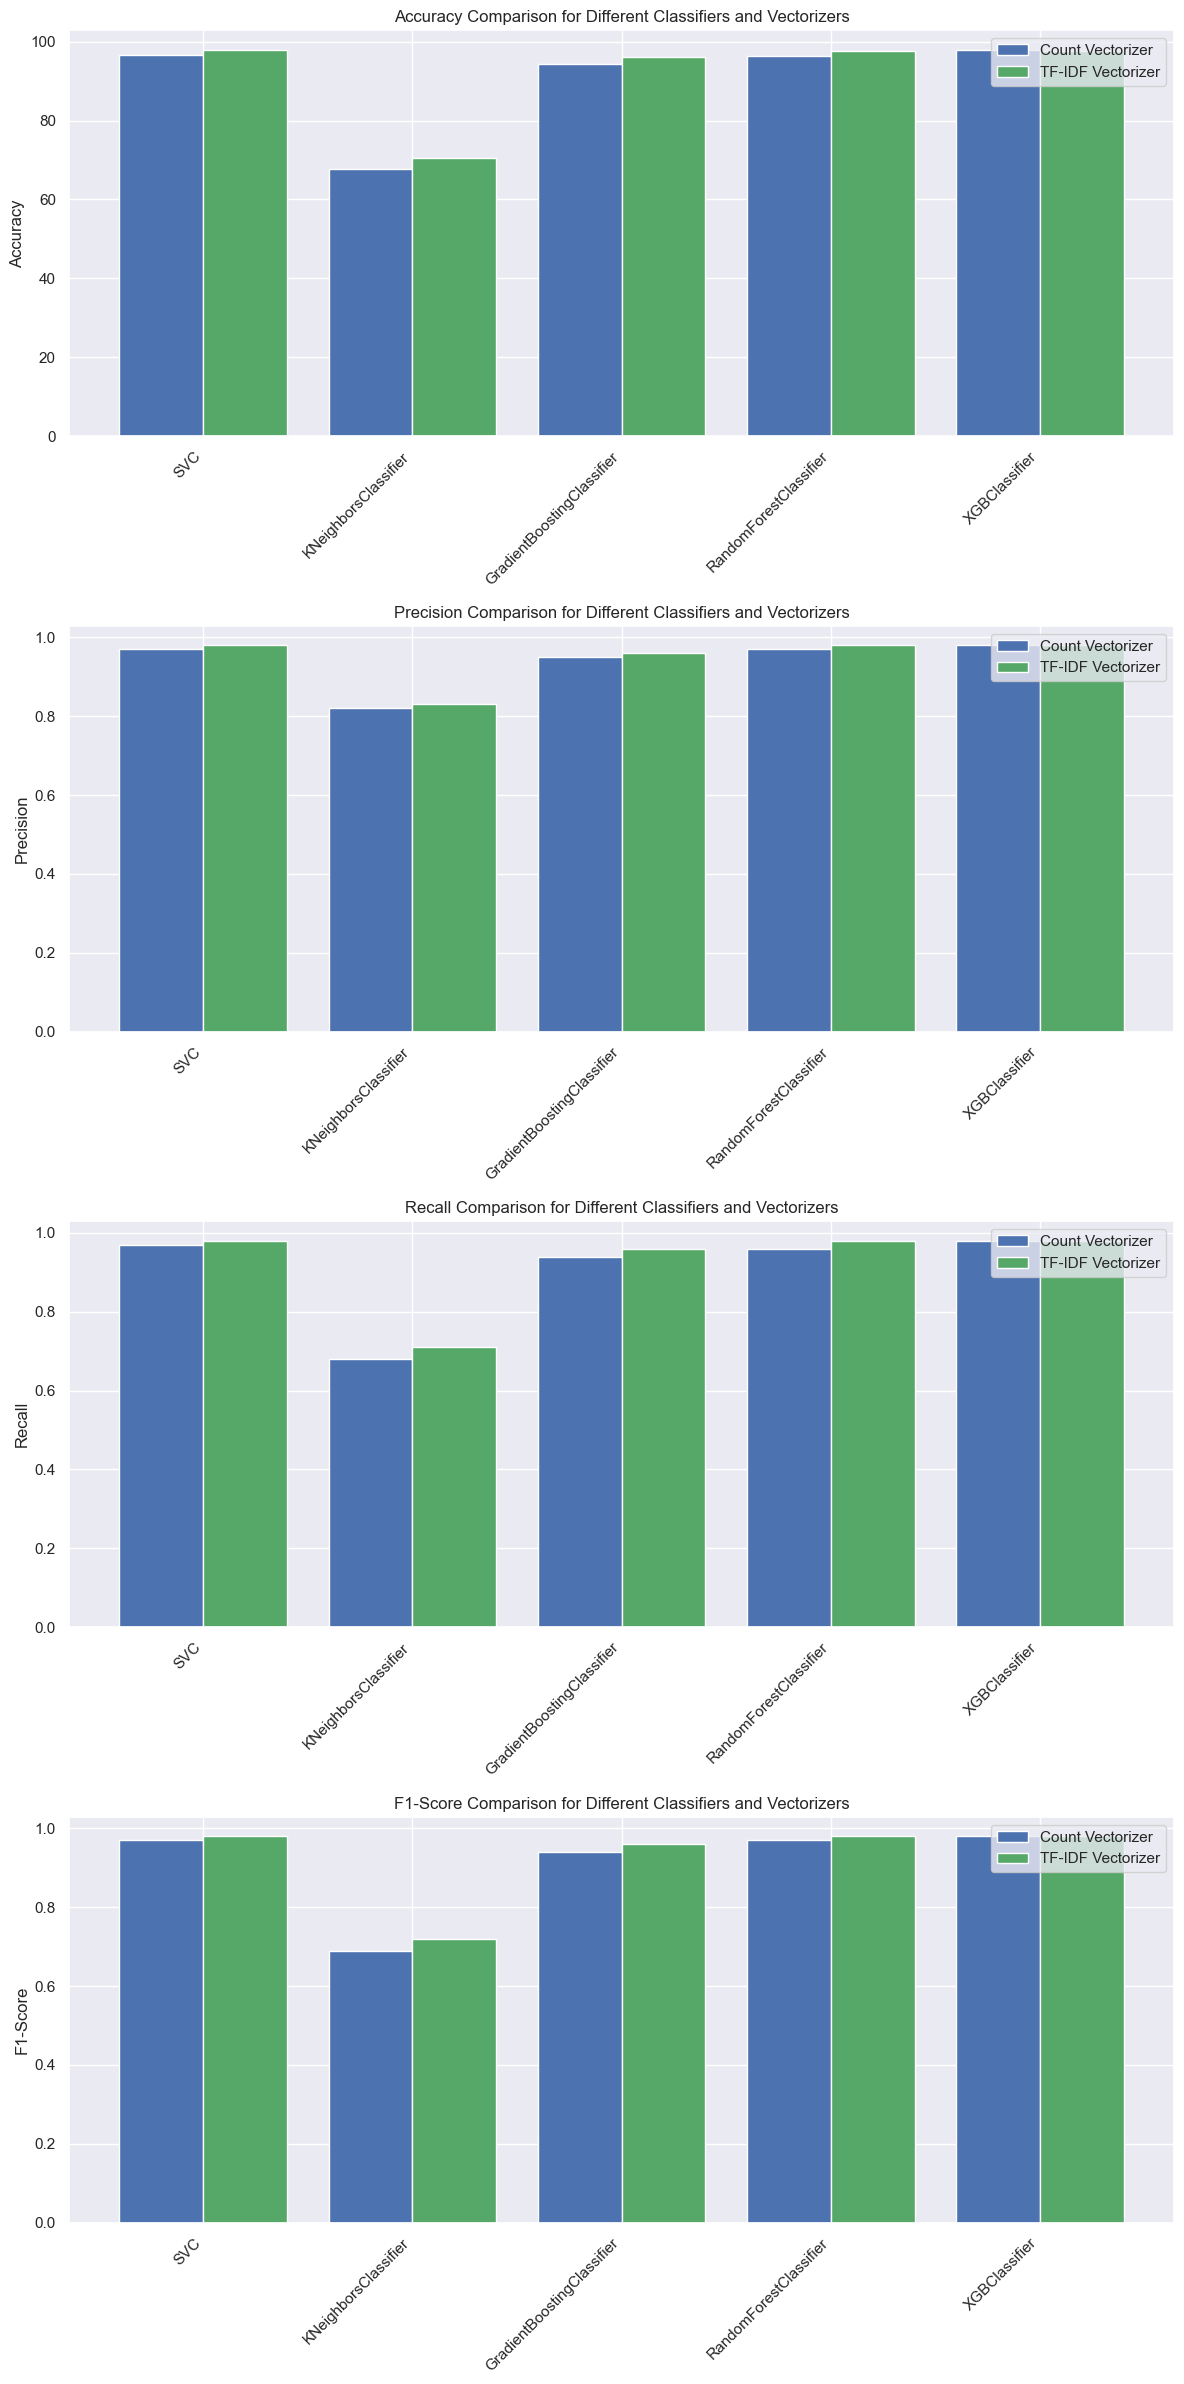

In [93]:

classifiers = [
    'SVC', 'KNeighborsClassifier',
    'GradientBoostingClassifier', 'RandomForestClassifier',
    'XGBClassifier'
]

test_metrics_count_vectorizer = {
    'Accuracy': [96.68, 67.73, 94.21, 96.47, 97.94],
    'Precision': [0.97, 0.82, 0.95, 0.97, 0.98],
    'Recall': [0.97, 0.68, 0.94, 0.96, 0.98],
    'F1-Score': [0.97, 0.69, 0.94, 0.97, 0.98]
}

test_metrics_tfidf_vectorizer = {
    'Accuracy': [97.81, 70.60, 96.05, 97.74, 97.69],
    'Precision': [0.98, 0.83, 0.96, 0.98, 0.98],
    'Recall': [0.98, 0.71, 0.96, 0.98, 0.98],
    'F1-Score': [0.98, 0.72, 0.96, 0.98, 0.98]
}

colors = ['b', 'g']

# Create subplots for each parameter
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
num_metrics = len(metrics)

fig, axs = plt.subplots(num_metrics, 1, figsize=(12, 6*num_metrics))

for i, metric in enumerate(metrics):
    ax = axs[i]
    
    x_pos = np.arange(len(classifiers))
    bar_width = 0.4
    
    ax.bar(x_pos - bar_width/2, test_metrics_count_vectorizer[metric], bar_width, label='Count Vectorizer', color=colors[0])
    ax.bar(x_pos + bar_width/2, test_metrics_tfidf_vectorizer[metric], bar_width, label='TF-IDF Vectorizer', color=colors[1])
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison for Different Classifiers and Vectorizers')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(classifiers, rotation=45, ha='right')
    ax.legend()

plt.tight_layout()
plt.show()
